In [11]:
from __future__ import annotations

import json
from collections import Counter
from pathlib import Path
import pandas as pd
import networkx as nx
from IPython.display import Markdown, display

BASE = Path(".")
OUT_DIR = BASE / "out"
MANUAL_PATH = OUT_DIR / "graph_manual.json"
NX_PATH = OUT_DIR / "graph_networkx.graphml"
IGRAPH_PATH = OUT_DIR / "graph_igraph.graphml"

assert MANUAL_PATH.exists(), "graph_manual.json não encontrado em out/"
assert NX_PATH.exists(), "graph_networkx.graphml não encontrado em out/"
assert IGRAPH_PATH.exists(), "graph_igraph.graphml não encontrado em out/"

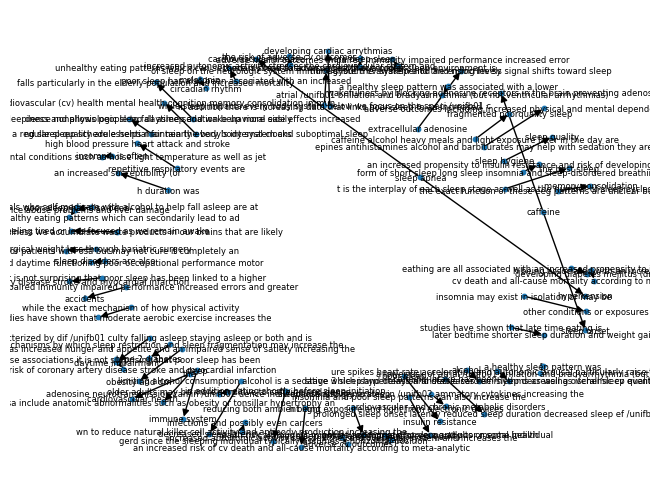

In [17]:
import matplotlib.pyplot as plt

g = nx.read_graphml(NX_PATH)
pos = nx.spring_layout(g, seed=10)
nx.draw(g, pos, node_size=10, with_labels=False, arrows=True)
nx.draw_networkx_labels(g, pos, font_size=6)
plt.show()

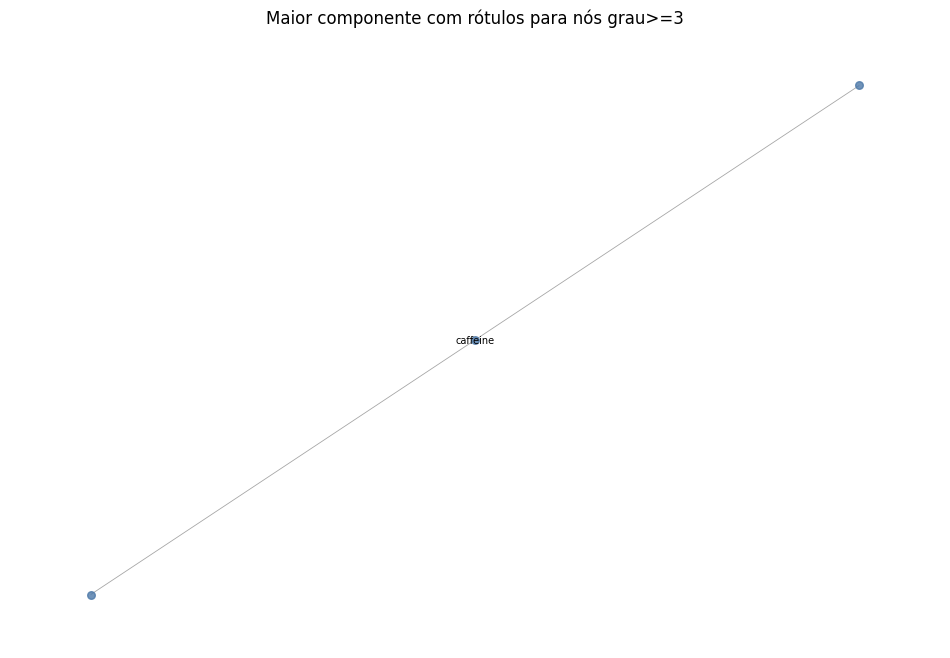

In [19]:
import matplotlib.pyplot as plt

# Visualização simplificada: maior componente e rótulos só em nós com grau>=3
# para reduzir sobreposição.
g = nx.read_graphml(NX_PATH)
ug = g.to_undirected()
largest = max(nx.connected_components(ug), key=len)
subg = g.subgraph(largest).copy()

pos = nx.spring_layout(subg, seed=10, k=0.35, iterations=200)
degree = dict(subg.degree())
labels = {n: n for n, d in degree.items() if d >= 2}

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(subg, pos, node_size=30, node_color="#4C78A8", alpha=0.8)
nx.draw_networkx_edges(subg, pos, width=0.6, alpha=0.35, arrows=False)
nx.draw_networkx_labels(subg, pos, labels=labels, font_size=7)
plt.title("Maior componente com rótulos para nós grau>=3")
plt.axis("off")
plt.show()


In [12]:
# Carrega grafo manual
with MANUAL_PATH.open("r", encoding="utf-8") as f:
    manual_data = json.load(f)

manual_nodes = set(manual_data["nodes"])
manual_edges = manual_data["edges"]
manual_rel_freq = Counter(e.get("rel", "") for e in manual_edges)

# Carrega grafo NetworkX
nx_graph = nx.read_graphml(str(NX_PATH))

# Garantir que atributos de relação existam
relations_nx = [nx_graph.edges[e].get("relation", "") for e in nx_graph.edges]
nx_rel_freq = Counter(relations_nx)

# Carrega grafo igraph (GraphML)
try:
    import igraph as ig

    ig_graph = ig.Graph.Read_GraphML(str(IGRAPH_PATH))
    ig_nodes = ig_graph.vs["name"] if "name" in ig_graph.vs.attributes() else [str(v.index) for v in ig_graph.vs]
    ig_relations = ig_graph.es["relation"] if "relation" in ig_graph.es.attributes() else [""] * ig_graph.ecount()
    ig_rel_freq = Counter(ig_relations)
except Exception as exc:
    ig_graph = None
    ig_nodes = []
    ig_relations = []
    ig_rel_freq = Counter()
    print(f"Aviso: falha ao carregar igraph: {exc}")


In [13]:
def hubs_from_manual(edges, top_k=10):
    out = Counter()
    inn = Counter()
    for e in edges:
        out[e["src"]] += 1
        inn[e["dst"]] += 1
    return out.most_common(top_k), inn.most_common(top_k)


def hubs_from_nx(g: nx.DiGraph, top_k=10):
    out_deg = Counter(dict(g.out_degree()))
    in_deg = Counter(dict(g.in_degree()))
    return out_deg.most_common(top_k), in_deg.most_common(top_k)


def hubs_from_ig(g, names, top_k=10):
    if g is None:
        return [], []
    out_deg = Counter(dict(zip(names, g.degree(mode="out"))))
    in_deg = Counter(dict(zip(names, g.degree(mode="in"))))
    return out_deg.most_common(top_k), in_deg.most_common(top_k)


manual_out, manual_in = hubs_from_manual(manual_edges, top_k=10)
nx_out, nx_in = hubs_from_nx(nx_graph, top_k=10)
ig_out, ig_in = hubs_from_ig(ig_graph, ig_nodes, top_k=10)

summary_counts = pd.DataFrame(
    [
        {
            "fonte": "manual",
            "nos": len(manual_nodes),
            "arestas": len(manual_edges),
        },
        {
            "fonte": "networkx",
            "nos": nx_graph.number_of_nodes(),
            "arestas": nx_graph.number_of_edges(),
        },
        {
            "fonte": "igraph",
            "nos": len(ig_nodes),
            "arestas": len(ig_relations),
        },
    ]
)

summary_rel = pd.DataFrame(
    [
        {"fonte": "manual", "relacao": k, "freq": v}
        for k, v in manual_rel_freq.most_common()
    ]
    + [
        {"fonte": "networkx", "relacao": k, "freq": v}
        for k, v in nx_rel_freq.most_common()
    ]
    + [
        {"fonte": "igraph", "relacao": k, "freq": v}
        for k, v in ig_rel_freq.most_common()
    ]
)

summary_hubs_out = pd.DataFrame(
    [{"fonte": "manual", "direcao": "out", "no": n, "grau": d} for n, d in manual_out]
    + [{"fonte": "networkx", "direcao": "out", "no": n, "grau": d} for n, d in nx_out]
    + [{"fonte": "igraph", "direcao": "out", "no": n, "grau": d} for n, d in ig_out]
)

summary_hubs_in = pd.DataFrame(
    [{"fonte": "manual", "direcao": "in", "no": n, "grau": d} for n, d in manual_in]
    + [{"fonte": "networkx", "direcao": "in", "no": n, "grau": d} for n, d in nx_in]
    + [{"fonte": "igraph", "direcao": "in", "no": n, "grau": d} for n, d in ig_in]
)

# Render como Markdown
display(Markdown("### Contagem de nós/arestas"))
display(Markdown(summary_counts.to_markdown(index=False)))

display(Markdown("### Top 10 relações (por frequência)"))
display(Markdown(summary_rel.head(10).to_markdown(index=False)))

display(Markdown("### Hubs de saída (top 10 por grau de saída)"))
display(Markdown(summary_hubs_out.head(10).to_markdown(index=False)))

display(Markdown("### Hubs de entrada (top 10 por grau de entrada)"))
display(Markdown(summary_hubs_in.head(10).to_markdown(index=False)))


### Contagem de nós/arestas

| fonte    |   nos |   arestas |
|:---------|------:|----------:|
| manual   |   131 |        68 |
| networkx |   131 |        68 |
| igraph   |   131 |        68 |

### Top 10 relações (por frequência)

| fonte   | relacao         |   freq |
|:--------|:----------------|-------:|
| manual  | associated with |     21 |
| manual  | risk of         |     13 |
| manual  | risk for        |      9 |
| manual  | increases       |      5 |
| manual  | impacts         |      3 |
| manual  | reduces         |      3 |
| manual  | promotes        |      3 |
| manual  | linked to       |      2 |
| manual  | improves        |      2 |
| manual  | leads to        |      1 |

### Hubs de saída (top 10 por grau de saída)

| fonte   | direcao   | no                                                                                |   grau |
|:--------|:----------|:----------------------------------------------------------------------------------|-------:|
| manual  | out       | increased                                                                         |      2 |
| manual  | out       | caffeine                                                                          |      2 |
| manual  | out       | sleep apnea                                                                       |      2 |
| manual  | out       | sleep                                                                             |      2 |
| manual  | out       | caffeine, alcohol, heavy meals, and light exposure later in the day are           |      1 |
| manual  | out       | nd sleep quality are essential for nearly every body system, and suboptimal sleep |      1 |
| manual  | out       | extracellular adenosine                                                           |      1 |
| manual  | out       | t is the interplay of each sleep stage as well as the number of sleep cycles that |      1 |
| manual  | out       | the exact function of these eeg patterns are unclear but are likely               |      1 |
| manual  | out       | while sleep impacts every body system, below we focus on the speci /unifb01 c     |      1 |

### Hubs de entrada (top 10 por grau de entrada)

| fonte   | direcao   | no                                                                                |   grau |
|:--------|:----------|:----------------------------------------------------------------------------------|-------:|
| manual  | in        | type 2 diabetes                                                                   |      2 |
| manual  | in        | fragmented poorquality sleep                                                      |      1 |
| manual  | in        | cardiovascular (cv) health, mental health, cognition, memory consolidation, immun |      1 |
| manual  | in        | throughout the awakeperiod, and rising levels signal shifts toward sleep          |      1 |
| manual  | in        | the best sleep                                                                    |      1 |
| manual  | in        | memory consolidation                                                              |      1 |
| manual  | in        | of sleep on the neurologic system, immune system, cv system, and the endocrine sy |      1 |
| manual  | in        | an increased propensity to insulin resistance and risk of developing diabetes mel |      1 |
| manual  | in        | developing diabetes mellitus (dm)                                                 |      1 |
| manual  | in        | obesity and dm                                                                    |      1 |

In [20]:
# Visualização tabular separada por fonte
from IPython.display import Markdown

for fonte in ["manual", "networkx", "igraph"]:
    rel_subset = summary_rel[summary_rel["fonte"] == fonte].head(10)
    hubs_out_subset = summary_hubs_out[summary_hubs_out["fonte"] == fonte].head(10)
    hubs_in_subset = summary_hubs_in[summary_hubs_in["fonte"] == fonte].head(10)

    display(Markdown(f"### {fonte} — Top 10 relações"))
    display(Markdown(rel_subset.to_markdown(index=False))) if not rel_subset.empty else display(Markdown("(sem dados)"))

    display(Markdown(f"### {fonte} — Hubs de saída (top 10)"))
    display(Markdown(hubs_out_subset.to_markdown(index=False))) if not hubs_out_subset.empty else display(Markdown("(sem dados)"))

    display(Markdown(f"### {fonte} — Hubs de entrada (top 10)"))
    display(Markdown(hubs_in_subset.to_markdown(index=False))) if not hubs_in_subset.empty else display(Markdown("(sem dados)"))


### manual — Top 10 relações

| fonte   | relacao         |   freq |
|:--------|:----------------|-------:|
| manual  | associated with |     21 |
| manual  | risk of         |     13 |
| manual  | risk for        |      9 |
| manual  | increases       |      5 |
| manual  | impacts         |      3 |
| manual  | reduces         |      3 |
| manual  | promotes        |      3 |
| manual  | linked to       |      2 |
| manual  | improves        |      2 |
| manual  | leads to        |      1 |

### manual — Hubs de saída (top 10)

| fonte   | direcao   | no                                                                                |   grau |
|:--------|:----------|:----------------------------------------------------------------------------------|-------:|
| manual  | out       | increased                                                                         |      2 |
| manual  | out       | caffeine                                                                          |      2 |
| manual  | out       | sleep apnea                                                                       |      2 |
| manual  | out       | sleep                                                                             |      2 |
| manual  | out       | caffeine, alcohol, heavy meals, and light exposure later in the day are           |      1 |
| manual  | out       | nd sleep quality are essential for nearly every body system, and suboptimal sleep |      1 |
| manual  | out       | extracellular adenosine                                                           |      1 |
| manual  | out       | t is the interplay of each sleep stage as well as the number of sleep cycles that |      1 |
| manual  | out       | the exact function of these eeg patterns are unclear but are likely               |      1 |
| manual  | out       | while sleep impacts every body system, below we focus on the speci /unifb01 c     |      1 |

### manual — Hubs de entrada (top 10)

| fonte   | direcao   | no                                                                                |   grau |
|:--------|:----------|:----------------------------------------------------------------------------------|-------:|
| manual  | in        | type 2 diabetes                                                                   |      2 |
| manual  | in        | fragmented poorquality sleep                                                      |      1 |
| manual  | in        | cardiovascular (cv) health, mental health, cognition, memory consolidation, immun |      1 |
| manual  | in        | throughout the awakeperiod, and rising levels signal shifts toward sleep          |      1 |
| manual  | in        | the best sleep                                                                    |      1 |
| manual  | in        | memory consolidation                                                              |      1 |
| manual  | in        | of sleep on the neurologic system, immune system, cv system, and the endocrine sy |      1 |
| manual  | in        | an increased propensity to insulin resistance and risk of developing diabetes mel |      1 |
| manual  | in        | developing diabetes mellitus (dm)                                                 |      1 |
| manual  | in        | obesity and dm                                                                    |      1 |

### networkx — Top 10 relações

| fonte    | relacao         |   freq |
|:---------|:----------------|-------:|
| networkx | associated with |     21 |
| networkx | risk of         |     13 |
| networkx | risk for        |      9 |
| networkx | increases       |      5 |
| networkx | impacts         |      3 |
| networkx | reduces         |      3 |
| networkx | promotes        |      3 |
| networkx | linked to       |      2 |
| networkx | improves        |      2 |
| networkx | leads to        |      1 |

### networkx — Hubs de saída (top 10)

| fonte    | direcao   | no                                                                                |   grau |
|:---------|:----------|:----------------------------------------------------------------------------------|-------:|
| networkx | out       | increased                                                                         |      2 |
| networkx | out       | caffeine                                                                          |      2 |
| networkx | out       | sleep apnea                                                                       |      2 |
| networkx | out       | sleep                                                                             |      2 |
| networkx | out       | caffeine, alcohol, heavy meals, and light exposure later in the day are           |      1 |
| networkx | out       | nd sleep quality are essential for nearly every body system, and suboptimal sleep |      1 |
| networkx | out       | extracellular adenosine                                                           |      1 |
| networkx | out       | t is the interplay of each sleep stage as well as the number of sleep cycles that |      1 |
| networkx | out       | the exact function of these eeg patterns are unclear but are likely               |      1 |
| networkx | out       | while sleep impacts every body system, below we focus on the speci /unifb01 c     |      1 |

### networkx — Hubs de entrada (top 10)

| fonte    | direcao   | no                                                                                |   grau |
|:---------|:----------|:----------------------------------------------------------------------------------|-------:|
| networkx | in        | type 2 diabetes                                                                   |      2 |
| networkx | in        | fragmented poorquality sleep                                                      |      1 |
| networkx | in        | cardiovascular (cv) health, mental health, cognition, memory consolidation, immun |      1 |
| networkx | in        | throughout the awakeperiod, and rising levels signal shifts toward sleep          |      1 |
| networkx | in        | the best sleep                                                                    |      1 |
| networkx | in        | memory consolidation                                                              |      1 |
| networkx | in        | of sleep on the neurologic system, immune system, cv system, and the endocrine sy |      1 |
| networkx | in        | an increased propensity to insulin resistance and risk of developing diabetes mel |      1 |
| networkx | in        | developing diabetes mellitus (dm)                                                 |      1 |
| networkx | in        | obesity and dm                                                                    |      1 |

### igraph — Top 10 relações

| fonte   | relacao         |   freq |
|:--------|:----------------|-------:|
| igraph  | associated with |     21 |
| igraph  | risk of         |     13 |
| igraph  | risk for        |      9 |
| igraph  | increases       |      5 |
| igraph  | impacts         |      3 |
| igraph  | reduces         |      3 |
| igraph  | promotes        |      3 |
| igraph  | linked to       |      2 |
| igraph  | improves        |      2 |
| igraph  | leads to        |      1 |

### igraph — Hubs de saída (top 10)

| fonte   | direcao   | no                                                                                |   grau |
|:--------|:----------|:----------------------------------------------------------------------------------|-------:|
| igraph  | out       | increased                                                                         |      2 |
| igraph  | out       | caffeine                                                                          |      2 |
| igraph  | out       | sleep apnea                                                                       |      2 |
| igraph  | out       | sleep                                                                             |      2 |
| igraph  | out       | caffeine, alcohol, heavy meals, and light exposure later in the day are           |      1 |
| igraph  | out       | nd sleep quality are essential for nearly every body system, and suboptimal sleep |      1 |
| igraph  | out       | extracellular adenosine                                                           |      1 |
| igraph  | out       | t is the interplay of each sleep stage as well as the number of sleep cycles that |      1 |
| igraph  | out       | the exact function of these eeg patterns are unclear but are likely               |      1 |
| igraph  | out       | while sleep impacts every body system, below we focus on the speci /unifb01 c     |      1 |

### igraph — Hubs de entrada (top 10)

| fonte   | direcao   | no                                                                                |   grau |
|:--------|:----------|:----------------------------------------------------------------------------------|-------:|
| igraph  | in        | type 2 diabetes                                                                   |      2 |
| igraph  | in        | fragmented poorquality sleep                                                      |      1 |
| igraph  | in        | cardiovascular (cv) health, mental health, cognition, memory consolidation, immun |      1 |
| igraph  | in        | throughout the awakeperiod, and rising levels signal shifts toward sleep          |      1 |
| igraph  | in        | the best sleep                                                                    |      1 |
| igraph  | in        | memory consolidation                                                              |      1 |
| igraph  | in        | of sleep on the neurologic system, immune system, cv system, and the endocrine sy |      1 |
| igraph  | in        | an increased propensity to insulin resistance and risk of developing diabetes mel |      1 |
| igraph  | in        | developing diabetes mellitus (dm)                                                 |      1 |
| igraph  | in        | obesity and dm                                                                    |      1 |